In [1]:
import sys
import ete3
import os
import random
from os import walk
sys.path.insert(0,'../scripts/')
from classDeclarationsAndFunctions import RootedTree
from fileIO import ReadRootedTree, ReadAlignment, WriteAlignment
from config import projectPath
from preprocess import GetAlignmentWithoutGapsAndAmbiguousChars, GetHighQualitySeqs
figures_path = projectPath + "figures/"
# projectPath = 

In [2]:
# Create SARS-CoV-2 datasets for scalability
print(projectPath)
subsampled_nextstrain_sarscov2 = projectPath + "data/nextstrain/subsampled_21_2_2023/aligned.fasta"
full_subsampled_alignment = ReadAlignment(subsampled_nextstrain_sarscov2)


/home/kalaghat/exaptation/Projects/MSTBasedForests/


In [17]:
high_qual_seqs = GetHighQualitySeqs(full_subsampled_alignment,quality_thresh=0.99)
alignment = full_subsampled_alignment
len(list(alignment.values())[0])

29903

In [19]:
high_qual_subsampled_alignment_trimmed = GetAlignmentWithoutGapsAndAmbiguousChars(high_qual_seqs)

TypeError: 'dict_values' object is not subscriptable

In [ ]:
seq_ids = list(full_subsampled_alignment.keys())
full_subsampled_alignment[seq_ids[0],seq_ids[1]]

In [ ]:
# create subsamples
from random import sample
seq_ids = list(high_qual_subsampled_alignment_trimmed.keys())

reps = 10
size_list = [500,1000,1500,2000]

for rep in range(reps):
    for size in size_list:
        resampled_ids = sample(seq_ids,size)
        resampled_aln = {}
        for seq_id in resampled_ids:
            resampled_aln[seq_id] = high_qual_subsampled_alignment_trimmed[seq_id]
        resampled_filename = projectPath+"data/nextstrain/subsampled_21_2_2023/resampled_"+str(size)+"_seqs_"+"rep_"+str(rep)+".fasta"
        WriteAlignment(resampled_aln,resampled_filename)
        print (size,rep)

In [ ]:
# create scripts for scalability
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
# Job scripts
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
iqtree_script = open("../batch_scripts/iqtree_sars_cov2_scalability.sh","w")
mstbackbone_script = open("../batch_scripts/mstbackbone_sars_cov2_scalability.sh","w")
fasttree_script = open("../batch_scripts/fastree_sars_cov2_scalability.sh","w")
raxml_script = open("../batch_scripts/raxml_sars_cov2_scalability.sh","w")

for rep in range(reps):
    for size in size_list:                
        mxqsub_prefix = ""        
        exp_id = "sars_cov2_size_"+str(size)+"_rep_"+str(rep)
        sequence_file_name = projectPath+"data/nextstrain/subsampled_21_2_2023/resampled_"+str(size)+"_seqs_"+"rep_"+str(rep)+".fasta"
        ###############        IQ-TREE      ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N iqtree_scale\t"
        # mxqsub_prefix += " --stderr=err_iqtree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_iqtree_scalability_"+exp_id
        iqtree_command = tools_path_geniux + "iqtree2"
        iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
        iqtree_command += ' -nt ' + str(1)
        iqtree_command += ' -seed 1234'
        # iqtreeCommand += ' -quiet'
        iqtree_command += ' -redo'
        iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
        iqtree_command += ' -m UNREST'
        iqtree_script.write(mxqsub_prefix + iqtree_command + "\n")
        ###############     MST-BACKBONE     ###################
        # mst_backbone_command
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N mstbackbone_scale\t"
        # mxqsub_prefix += " --stderr=err_mstbackbone_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_mstbackbone_scalability_" + exp_id
        mst_backbone_command = tools_path_geniux + "mst-backbone"
        mst_backbone_command += '\t--seq ' + sequence_file_name
        mst_backbone_command += '\t--out ' + exp_id
        mstbackbone_script.write(mxqsub_prefix + mst_backbone_command + "\n")
        ###############        RAxML-NG       ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N raxmlng_scale\t"
        # mxqsub_prefix += " --stderr=err_raxmlng_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_raxmlng_scalability_" + exp_id
        raxml_command = tools_path_geniux + "raxml-ng"
        fileNamePrefix = 'RAxMLNG_' + exp_id
        raxml_command += ' --tree pars{1}'
        raxml_command += ' --model GTR --msa ' + sequence_file_name
        raxml_command += ' --threads 1'
        # raxml_command += ' --redo '
        raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
        raxml_command += ' --prefix ' + fileNamePrefix
        raxml_script.write(mxqsub_prefix + raxml_command + "\n")
        #############          FastTree        ################
        # mxqsub_prefix = ""
        # mxqsub_prefix = "mxqsub -t 2d -m 1G -n -N fasttree_scale\t"
        # mxqsub_prefix += " --stderr=err_fasttree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_fasttree_scalability_"+exp_id
        output_tree_file_name = sequence_file_name + '.fasttree_newick'
        std_err_file_name = sequence_file_name + '.fasttree_errlog'
        fasttree_command = tools_path_geniux + 'FastTree'
        fasttree_command += ' -nt -nosupport -nocat -gtr < '+ sequence_file_name
        fasttree_command += ' > ' + output_tree_file_name
        fasttree_command += ' 2> ' + std_err_file_name
        fasttree_script.write(mxqsub_prefix + fasttree_command + "\n")
        ########################################################



fasttree_script.close()
raxml_script.close()
mstbackbone_script.close()
iqtree_script.close()

In [4]:
def Get_run_time(method,size,rep):
    # print(method, exp_id)
    sequence_file_name = projectPath + "data/nextstrain/subsampled_21_2_2023/resampled_"+str(size)+"_seqs_"+"rep_"+str(rep)+".fasta"
    exp_id = "sars_cov2_size_"+str(size)+"_rep_"+str(rep)
    runTime = -1
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        tree_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree'
        if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
            if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
                log_file = open(log_file_name,"r")
                for line in log_file:
                    if line.startswith('Elapsed time:'):
                        runTime = float(line.strip().split('Elapsed time:')[1].split(' seconds')[0])
                log_file.close()
    elif method == "mstbackbone":
        log_file_name = projectPath + "data/nextstrain/subsampled_21_2_2023/" + exp_id + '.mstbackbone_log'
        tree_file_name = projectPath + "data/nextstrain/subsampled_21_2_2023/" + exp_id +  '.unrooted_newick'
        if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
            if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
                log_file = open(log_file_name,"r")
                for line in log_file:
                    if line.startswith('Total CPU time used is '):
                        runTime = float(line.split('Total CPU time used is ')[1].split(' second(s)')[0])
                log_file.close()    
    elif method == "fasttree":
        log_file_name = sequence_file_name + '.fasttree_errlog'
        tree_file_name = sequence_file_name + '.fasttree_newick'
        if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
            if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
                log_file = open(log_file_name,"r")
                for line in log_file:
                    if line.startswith('Total time: '):
                        runTime = float(line.strip().split('Total time: ')[1].split(' seconds')[0])
                log_file.close()
    elif method == "iqtree":
        log_file_name = sequence_file_name + '_iqtree2.0.log'
        tree_file_name = sequence_file_name + '_iqtree2.0.treefile'
        if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
            if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
                log_file = open(log_file_name,"r")
                for line in log_file:
                    if line.startswith('Total CPU time used:'):
                        runTime = float(line.split('Total CPU time used: ')[1].split(' sec')[0])
                log_file.close()
    return (runTime)

In [3]:
size = 1000
rep = 0
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
method = method_list[0]
Get_run_time(method,size,rep)
# log_file_name = projectPath + "data/nextstrain/subsampled_21_2_2023/resampled_"+str(size)+"_seqs_"+"rep_"+str(rep)+ '.mstbackbone_log'        
# tree_file_name = projectPath + "data/nextstrain/subsampled_21_2_2023/resampled_"+str(size)+"_seqs_"+"rep_"+str(rep)+ '.unrooted_newick'
# print(log_file_name)
# os.path.exists(log_file_name)

274.939

In [6]:
# Store run times

method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
run_times_method = {}
num_leaves_method = {}
reps = 10
size_list = [1000,1500,2000,2500,3000]
for method in method_list:
    run_times_method[method] = []
    num_leaves_method[method] = []
    for rep in range(reps):
        for size in size_list:        
            run_time = Get_run_time(method,size,rep)
            if run_time > 0:
                run_times_method[method].append(run_time)
                num_leaves_method[method].append(size)
            

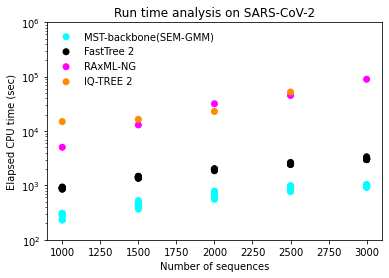

In [23]:
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
method_colors = {}
method_colors_map = {}
method_colors_map['mstbackbone'] = ['cyan']
method_colors_map['fasttree'] = ['black']
method_colors_map['raxmlng'] = ['fuchsia']
method_colors_map['iqtree'] = ['darkorange']
method_colors_map['mst'] = ['darkblue']
import matplotlib.pyplot as plt

for method in method_list:
    method_colors[method] = method_colors_map[method] * len(num_leaves_method[method])    
    plt.scatter(num_leaves_method[method],run_times_method[method],label=method,c=method_colors[method])
    plt.title("Run time analysis on SARS-CoV-2")
    plt.xlabel("Number of sequences")
    plt.ylabel("Elapsed CPU time (sec)")
    plt.yscale("log")

plt.ylim(pow(10,2),pow(10,6))
plt.legend(['MST-backbone(SEM-GMM)','FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(0.0,1.0), loc ="upper left", frameon=False)
# plt.set_size_inches(13, 10)
plt.savefig(figures_path+"sars_cov_2_scalability.eps", dpi=100,bbox_inches='tight')
plt.savefig(figures_path+"sars_cov_2_scalability.png", dpi=100,bbox_inches='tight')

In [19]:
run_times_method

{'mstbackbone': [],
 'fasttree': [884.28,
  1411.06,
  2001.88,
  2440.82,
  3082.18,
  855.01,
  1418.34,
  1978.96,
  2509.82,
  2975.87,
  860.92,
  1370.75,
  1986.91,
  2446.05,
  3133.37,
  891.84,
  1443.88,
  1955.39,
  2645.44,
  3054.27,
  891.07,
  1349.51,
  2025.8,
  2456.56,
  3013.0,
  874.54,
  1401.28,
  1919.11,
  2573.33,
  3009.72,
  936.29,
  1442.67,
  1947.2,
  2466.43,
  3159.88,
  905.89,
  1380.0,
  1942.15,
  2509.9,
  3366.08,
  897.81,
  1479.36],
 'raxmlng': [5038.369, 12990.253, 31753.293],
 'iqtree': []}